In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_distribution, plot_histogram, plot_bloch_multivector
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.circuit.library import CPhaseGate
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from utils import get_image_path

In [2]:
def random_file_name(size=5):
    return ''.join(random.sample(list(ascii_lowercase), size))

In [3]:
def create_test_folder(folder):
    if(os.path.exists(folder)):
        print("Path already exists")
        print(f"Removing {folder}")
        shutil.rmtree(folder, ignore_errors=True)
    
    print(f"Creating: {folder}")
    os.mkdir(folder)
        
def create_test_files(folder, n=5):
    create_test_folder(folder)
    for _ in range(n):
        file = random_file_name()+".txt"
        
        try:
            print(f"creating file: {file}")
            file_path = os.path.join(folder, file)

            file = open(file_path, "a")
            file.close()
        
        except Exception as error:
            print(f"Failed creating {file}")


test_folder = os.path.join('.', 'files-test')
create_test_files(test_folder)

Creating: ./files-test
creating file: ajvcy.txt
creating file: vitgb.txt
creating file: gukjv.txt
creating file: ouvgd.txt
creating file: xyajp.txt


In [4]:
files = os.listdir(test_folder)
files

['vitgb.txt', 'ouvgd.txt', 'ajvcy.txt', 'xyajp.txt', 'gukjv.txt']

In [5]:
selected_file = files[random.randint(0,len(files))]
selected_file

'gukjv.txt'

In [6]:
def classical_method_1(files, target):
    #in this example, we are ignoring the extension
    #just for this case, in real life a good idea is to use the entire name, or a hash of it

    #unsing no type of lookup table, or sorting, the algorithm takes O(n)
    total_tests = 0
    for file in files:
        total_tests += 1
        print(f"total tests: {total_tests}")
        if(file == target):
            print("found file")
            break

classical_method_1(files, selected_file)

total tests: 1
total tests: 2
total tests: 3
total tests: 4
total tests: 5
found file


In [7]:
def classical_method_2(files, target):

    # this should be done after adding a file into the filesystem
    # it takes O(1) for adding a new file, O(n) for adding n files and O(1) for searching
    lut = {}
    for file in files:
        file_hash = hash(file)
        lut[file_hash] = file

    target_hash = hash(target)
    if lut.get(target_hash):
        print("File found")
    else:
        print("File doesnt exists in the filesystem")
        
classical_method_2(files, selected_file)

File found


---

In [8]:
n_qubits = int(np.ceil(np.log2(len(files))))

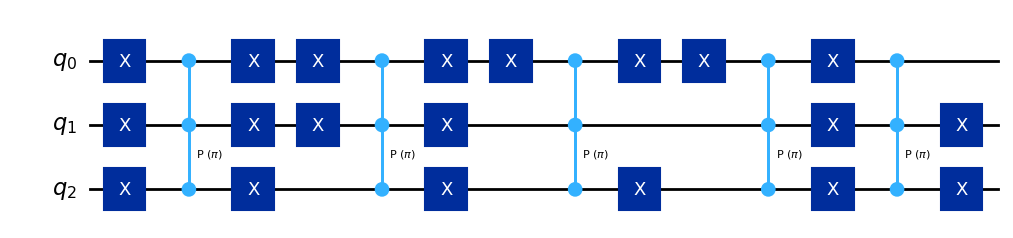

In [9]:
def encoding_files_to_oracle(n_qubits, files):
    oracle = QuantumCircuit(n_qubits, name="LUT")

    encoded_bin = [bin(i)[2:].zfill(n_qubits)[::-1] for i in range(len(files))]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

binary,oracle = encoding_files_to_oracle(n_qubits,files)
oracle.draw('mpl', filename=get_image_path("look-up-table.png"))

In [10]:
def get_oracle_overload(files, targets):
    oracle = QuantumCircuit(n_qubits, name="$LUT^{-1}$")

    encode = lambda x,n: bin(x)[2:].zfill(n)[::-1]
    encoded_bin = [encode(i,n_qubits) for i, file in enumerate(files) if file not in targets]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

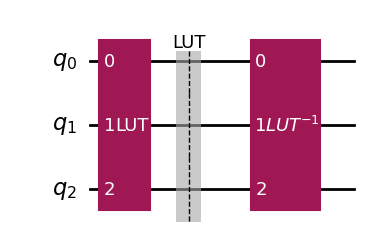

In [77]:
lut_binary,oracle = encoding_files_to_oracle(n_qubits,files)
unvalid_states,oracle_inv = get_oracle_overload(files, [selected_file])

good_state = list(set(lut_binary) - set(unvalid_states))

n_qubits = len(oracle.qubits)

qc = QuantumCircuit(n_qubits)
qc.append(oracle, range(n_qubits))
qc.barrier(label="LUT")
qc.append(oracle_inv, range(n_qubits))
qc.draw('mpl', filename=get_image_path("sets-difference-look-up-table-oracle.png"))

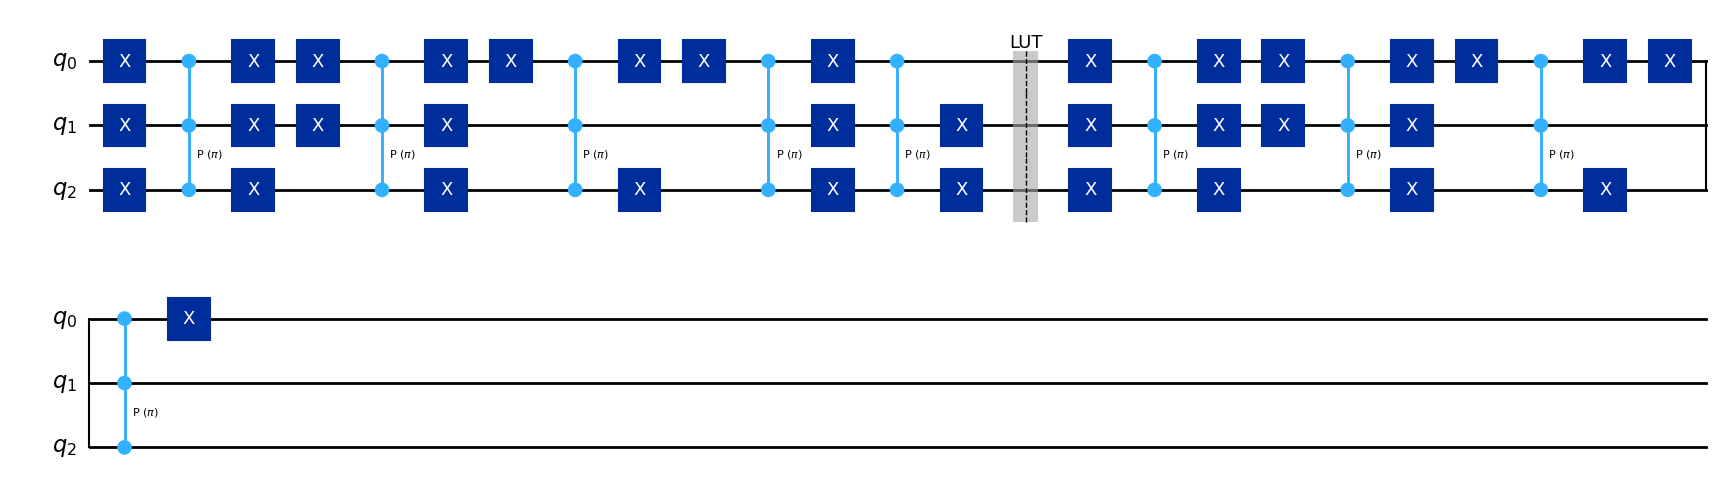

In [78]:
qc.decompose().draw('mpl')

In [79]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

In [80]:
qc_copy = qc.copy()
qc_copy.save_unitary()

sim = AerSimulator()
unitary = sim.run(transpile(qc_copy, sim)).result().get_unitary()
array_to_latex(unitary, max_size=10000)

<IPython.core.display.Latex object>

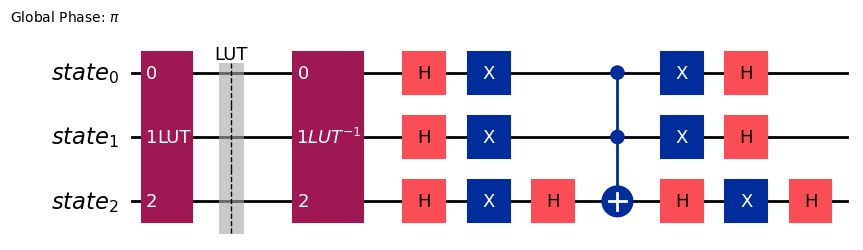

In [81]:
problem = AmplificationProblem(qc, is_good_state=good_state)
problem.grover_operator.decompose().draw(output='mpl', filename=get_image_path("classical_grover_file_search.png"))

In [82]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.top_measurement

'001'

---

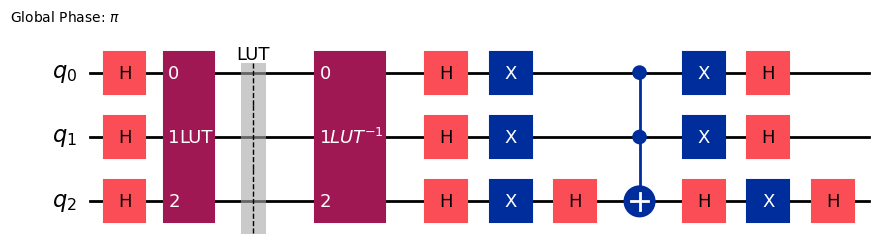

In [83]:
qc = QuantumCircuit(3)
qc.h(range(3))
qc.compose(problem.grover_operator.decompose(), range(3), inplace=True)
qc.draw('mpl', filename=get_image_path("file_explorer.png"))

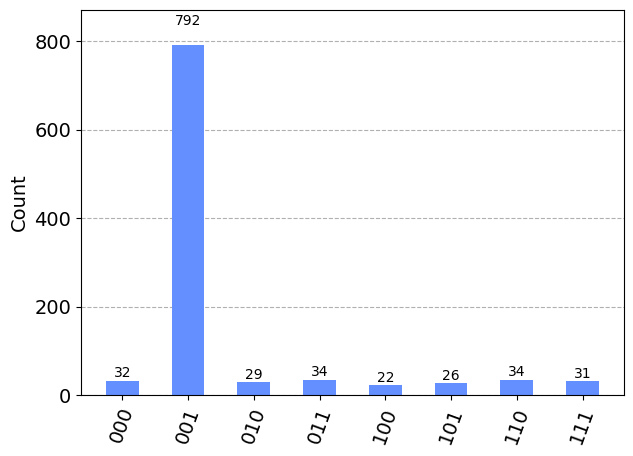

<Figure size 640x480 with 0 Axes>

In [84]:
sim = AerSimulator()
qc_copy = qc.copy()
qc_copy.measure_all()
aer_result = sim.run(transpile(qc_copy, sim), shots=1000).result().get_counts()
plot_histogram(aer_result, filename=get_image_path('AER_file_explorer_result.png'))

---

In [85]:
def create_new_grover(file):
    n_qubits = int(np.ceil(np.log2(len(files))))
    lut_binary, oracle = encoding_files_to_oracle(n_qubits,files)
    unvalid_states,oracle_inv = get_oracle_overload(files, [file])

    
    good_state = list(set(lut_binary) - set(unvalid_states))
    print('good state: ', good_state)
    t_qubits = len(oracle.qubits)

    final_oracle = QuantumCircuit(t_qubits)
    final_oracle.append(oracle, range(t_qubits))
    final_oracle.barrier(label="LUT")
    final_oracle.append(oracle_inv, range(t_qubits))


    total_zeros = good_state[0].count('0')
    """
    angles from the grover tests
    000		1.013620
    001		1.385071
    010		1.479508
    011		1.680972
    100		1.397662
    101		1.712451
    110		1.699860
    111		2.058719
    """
    angles = {
        "000":1.013620,
        "001":1.385071,
        "010":1.479508,
        "011":1.680972,
        "100":1.397662,
        "101":1.712451,
        "110":1.699860,
        "111":2.058719
    }


    problem = AmplificationProblem(final_oracle, is_good_state=good_state)
    
    qc = QuantumCircuit(t_qubits)
    qc.ry(angles[good_state[0]], range(t_qubits))
    qc.compose(problem.grover_operator.decompose(), range(t_qubits), inplace=True)
    
    return qc

good state:  ['100']


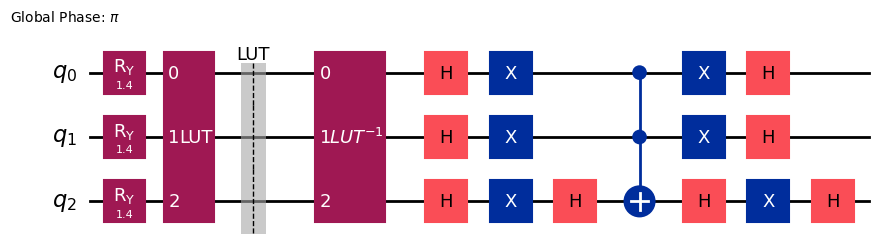

In [87]:
new_qc = create_new_grover(selected_file)
new_qc.draw('mpl', filename=get_image_path("improved_file_explorer.png"))

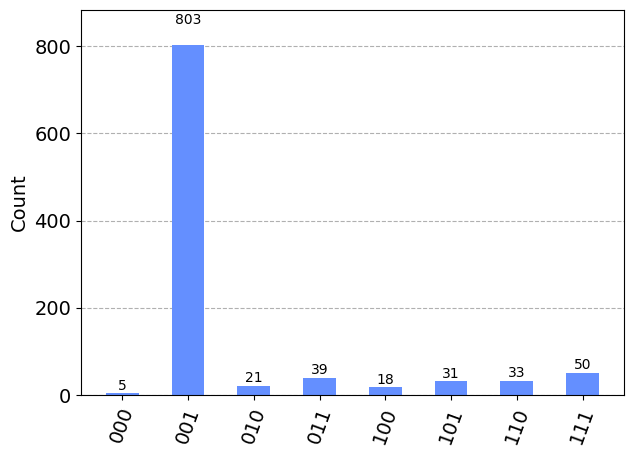

<Figure size 640x480 with 0 Axes>

In [90]:
sim = AerSimulator()
qc_copy = new_qc.copy()
qc_copy.measure_all()
aer_result = sim.run(transpile(qc_copy, sim), shots=1000).result().get_counts()
hist = plot_histogram(aer_result)
plt.savefig(get_image_path("AER-file-explorer-hist-new-grover-mapped-rotations.png"))
display(hist)

---

In [199]:
x = np.array(list(range(0, 60)), dtype=np.int64)

classical_find = lambda x: x
classical_lut = lambda x: 1
quantum = lambda x: np.sqrt(x)

vec_cf = np.vectorize(classical_find)
vec_cl = np.vectorize(classical_lut)
vec_q = np.vectorize(quantum)

y_classical_f = vec_cf(x)
y_classical_l = vec_cl(x)
y_quantum = vec_q(x)

In [200]:
df = pd.DataFrame({"x":x, "cf":y_classical_f, "cl":y_classical_l, "q":y_quantum})
df.head()

,x,cf,cl,q
0,0,0,1,0.000000
1,1,1,1,1.000000
2,2,2,1,1.414214
3,3,3,1,1.732051
4,4,4,1,2.000000


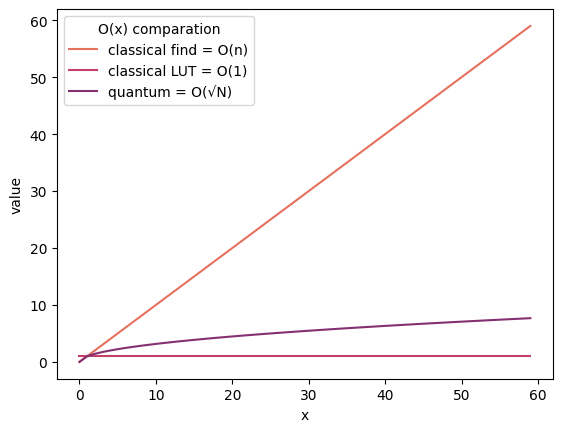

In [201]:
plot = sns.lineplot(data=pd.melt(df, ["x"]), x="x", y="value", hue="variable", palette="flare")

legend = plot.axes.get_legend()
legend.set_title("O(x) comparation")
for old, new in zip(legend.texts, ["classical find = O(n)", "classical LUT = O(1)", "quantum = O(√N)"]):
    old.set_text(new)

    
plt.savefig(get_image_path("algorithms-finding-comparation.png"))
plt.show(plot)

---

In [31]:
def get_result(qc, sim=AerSimulator()):
    g_copy = qc.copy()
    g_copy.measure_all()
    sim = AerSimulator()
    return sim.run(transpile(g_copy, sim), shots=1000).result().get_counts()

In [32]:
def new_g(superposition, oracle):
    qc = QuantumCircuit(3)
    qc.append(superposition, range(3))
    qc.append(oracle, range(3))
    qc.h(range(3))
    qc.x(range(3))
    qc.h(-1)
    qc.ccx(0, 1,2)
    qc.h(-1)
    qc.x(range(3))
    qc.h(range(3))
    return qc

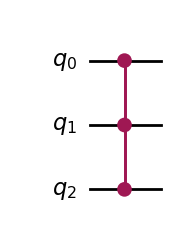

In [33]:
oracle = QuantumCircuit(3, name="oracle")
oracle.ccz(0, 1,2)
oracle.draw('mpl')

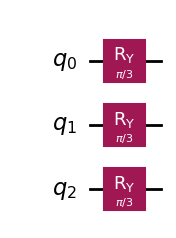

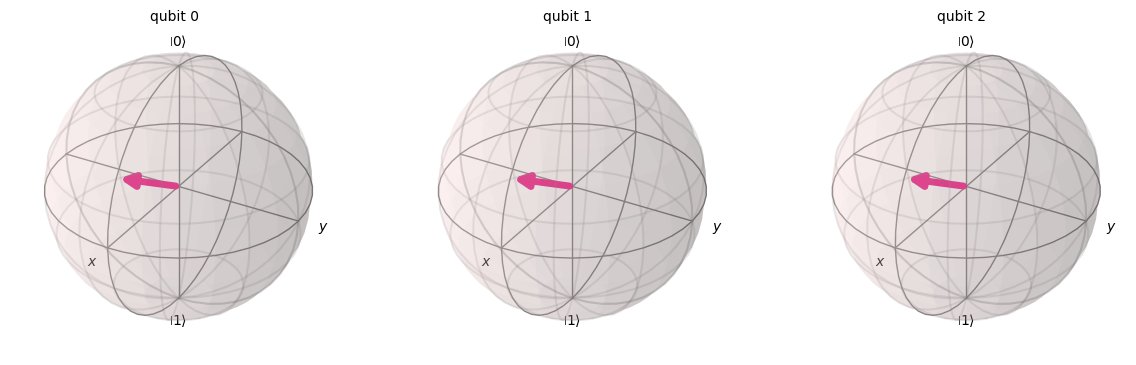

In [34]:
s = QuantumCircuit(3, name="s")
s.ry(np.pi/3, range(3))
display(s.draw('mpl'))
plot_bloch_multivector(s)

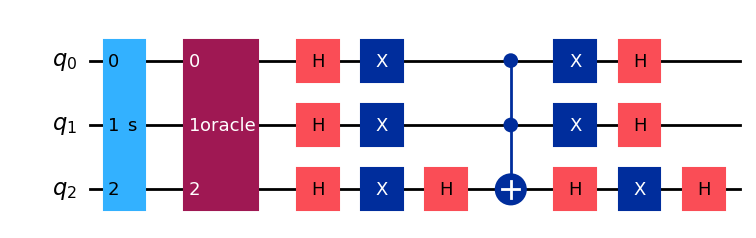

In [35]:
qc = new_g(s, oracle)
qc.draw('mpl')

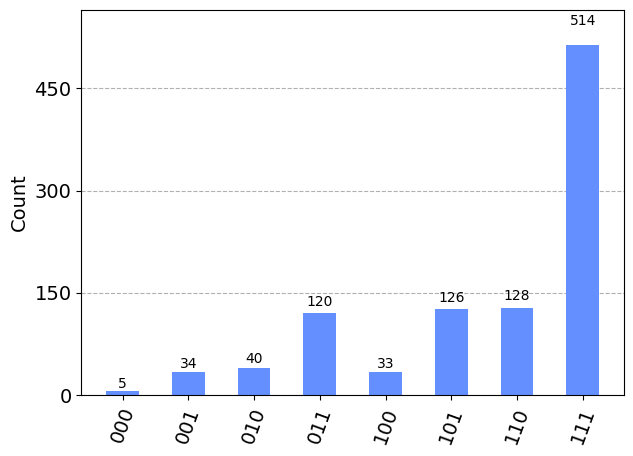

In [36]:
plot_histogram(get_result(qc))

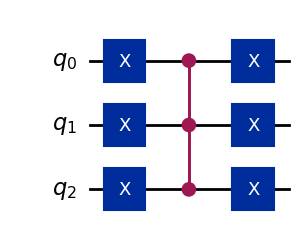

In [37]:
oracle = QuantumCircuit(3, name="oracle")
oracle.x(range(3))
oracle.ccz(0, 1,2)
oracle.x(range(3))

oracle.draw('mpl')

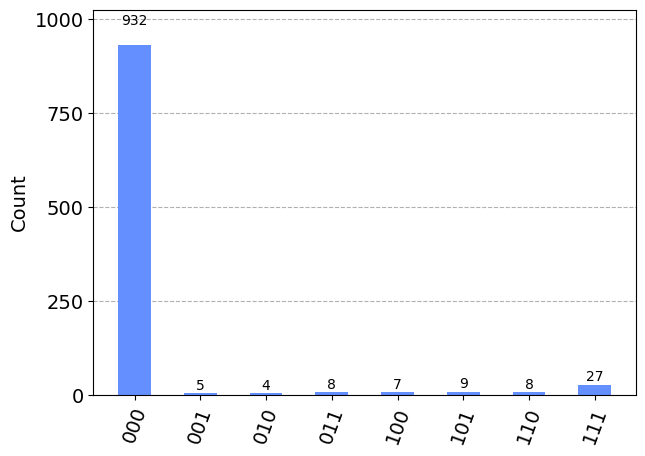

In [38]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

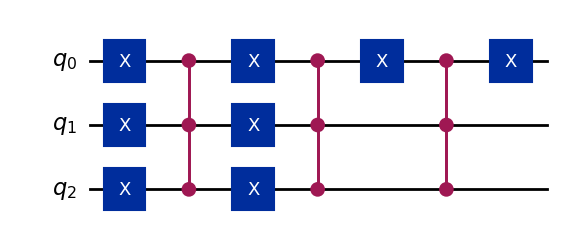

In [39]:
oracle = QuantumCircuit(3, name="oracle")
oracle.x(range(3))
oracle.ccz(0, 1,2)
oracle.x(range(3))
oracle.ccz(0,1,2)
oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)

oracle.draw('mpl')

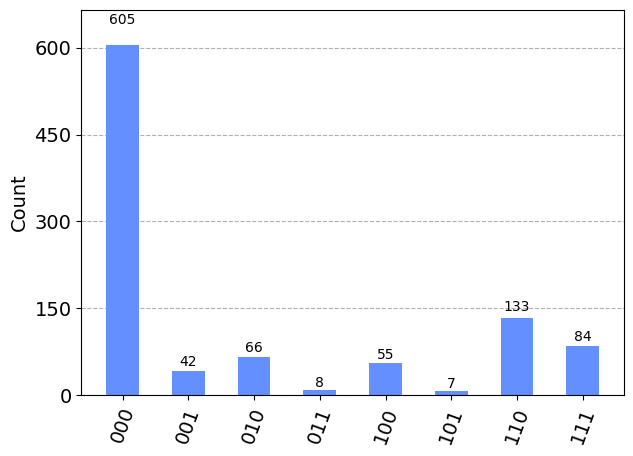

In [40]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

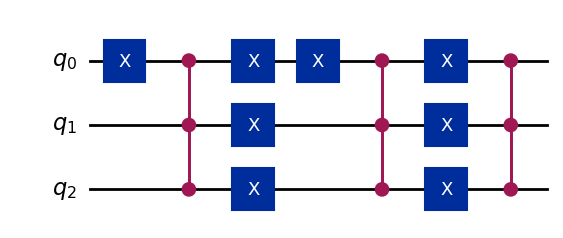

In [41]:
oracle = QuantumCircuit(3, name="oracle")
oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)
oracle.x(range(3))
oracle.ccz(0, 1,2)
oracle.x(range(3))
oracle.ccz(0,1,2)


oracle.draw('mpl')

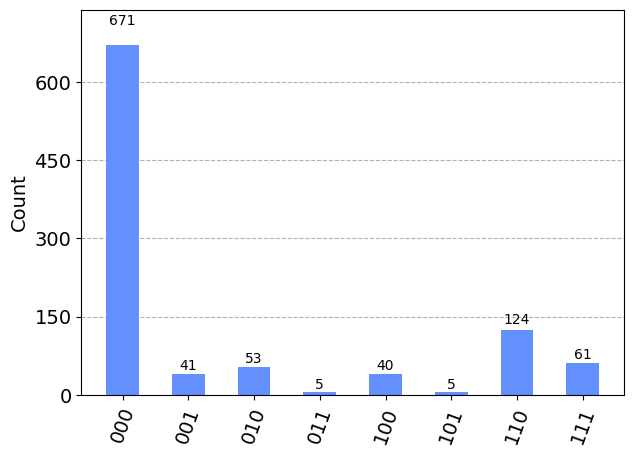

In [42]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

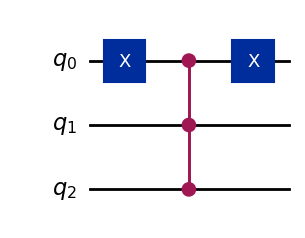

In [43]:
oracle = QuantumCircuit(3, name="oracle")
oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)


oracle.draw('mpl')

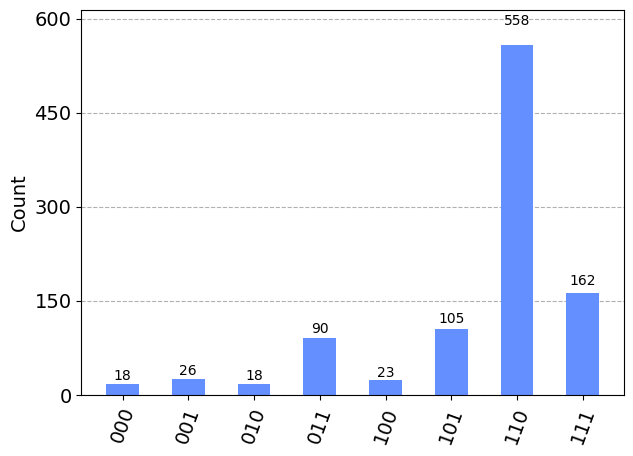

In [44]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

In [45]:
sim = AerSimulator()

def find_best_angle(encoded_bit_string, oracle):
    max_ = 0
    best_angle = 0
    
    for angle in np.linspace(0, np.pi, num=120):        
        s = QuantumCircuit(3)
        s.ry(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
    
        print(angle, result)
    return best_angle, max_

oracle = QuantumCircuit(3)
oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)


best_angle, max_ = find_best_angle('110', oracle)

0.0 67
0.026399938265460447 67
0.05279987653092089 66
0.07919981479638134 88
0.10559975306184179 82
0.13199969132730224 86
0.1583996295927627 102
0.18479956785822313 103
0.21119950612368357 112
0.23759944438914402 111
0.2639993826546045 129
0.29039932092006493 116
0.3167992591855254 164
0.3431991974509858 144
0.36959913571644626 159
0.3959990739819067 157
0.42239901224736714 182
0.4487989505128276 214
0.47519888877828803 240
0.5015988270437485 243
0.527998765309209 256
0.5543987035746694 251
0.5807986418401299 264
0.6071985801055902 285
0.6335985183710507 322
0.6599984566365111 323
0.6863983949019716 319
0.712798333167432 330
0.7391982714328925 366
0.7655982096983529 391
0.7919981479638134 375
0.8183980862292738 415
0.8447980244947343 424
0.8711979627601948 446
0.8975979010256552 496
0.9239978392911157 483
0.9503977775565761 492
0.9767977158220366 498
1.003197654087497 540
1.0295975923529574 542
1.055997530618418 546
1.0823974688838782 569
1.1087974071493387 603
1.1351973454147992 615


In [46]:
best_angle, max_

(1.7687958637858499, 811)

In [47]:
np.degrees(best_angle)

101.34453781512605

In [48]:
np.pi/4

0.7853981633974483

In [49]:
(np.pi*11)/20

1.727875959474386

In [50]:
np.pi - ((np.pi*10)/18) - (np.pi/4)

0.6108652381980153

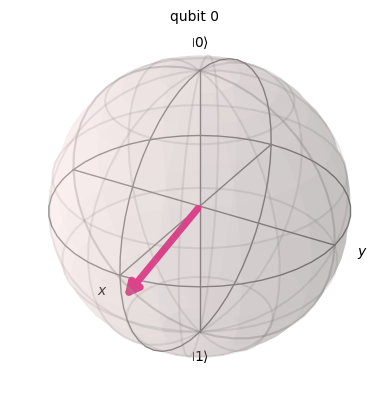

In [51]:
qc = QuantumCircuit(1)
qc.ry(best_angle, 0)
plot_bloch_multivector(qc)

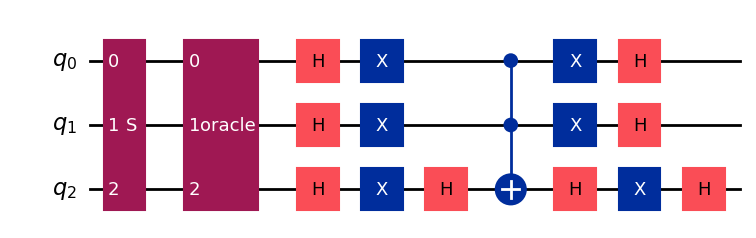

In [52]:
s = QuantumCircuit(3, name="S")
s.ry(best_angle, range(3))

oracle = QuantumCircuit(3, name="oracle")
oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)

qc = new_g(s, oracle)
qc.draw('mpl')

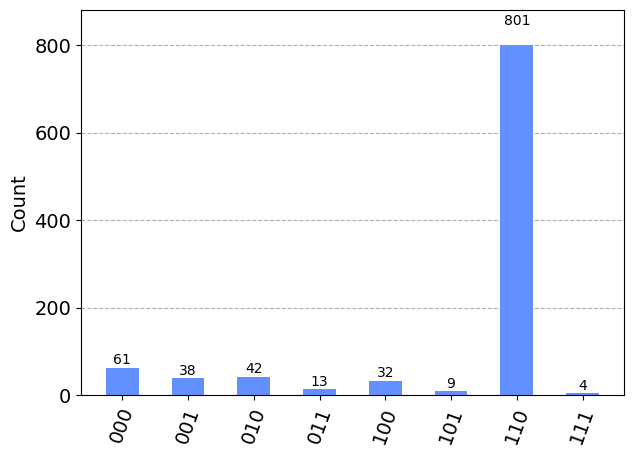

In [53]:
plot_histogram(get_result(qc))

In [54]:
s = QuantumCircuit(3, name="S")
s.ry(best_angle, range(3))

oracle = QuantumCircuit(3, name="oracle")
oracle.ccz(0,1,2)

qc = new_g(s, oracle)

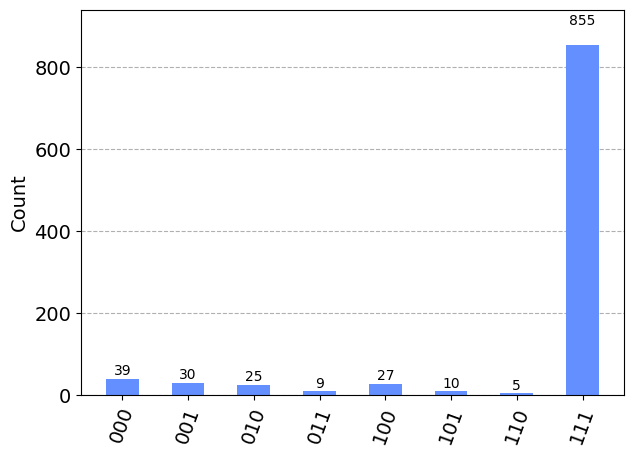

In [55]:
plot_histogram(get_result(qc))

In [56]:
s = QuantumCircuit(3, name="S")
s.ry(best_angle, range(3))

oracle = QuantumCircuit(3, name="oracle")
#oracle.ccz(0,1,2)

oracle.x(range(3))
oracle.ccz(0,1,2)
oracle.x(range(3))

oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)

qc = new_g(s, oracle)

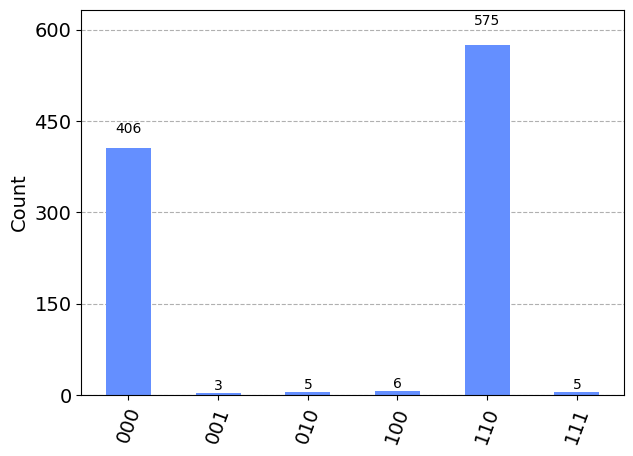

In [57]:
plot_histogram(get_result(qc))

In [58]:
oracle = QuantumCircuit(3, name="oracle")
oracle.ccz(0,1,2)

oracle.x(range(3))
oracle.ccz(0,1,2)
oracle.x(range(3))

oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)

oracle.x(0)
oracle.x(1)
oracle.ccz(0,1,2)
oracle.x(0)
oracle.x(1)

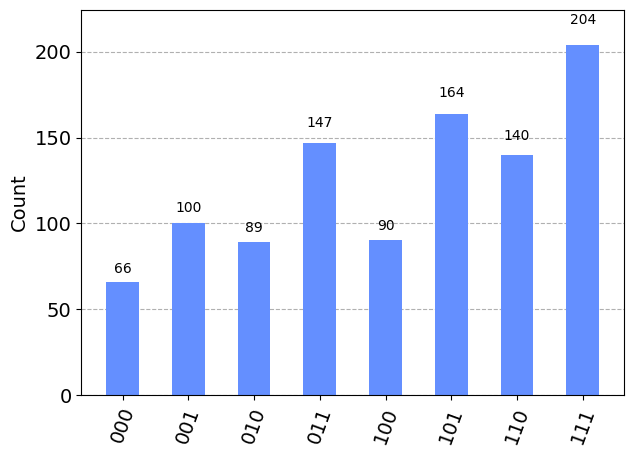

In [59]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

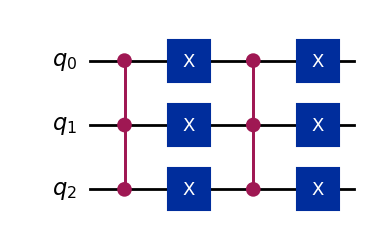

In [60]:
oracle = QuantumCircuit(3, name="oracle")
oracle.ccz(0,1,2)

oracle.x(range(3))
oracle.ccz(0,1,2)
oracle.x(range(3))
oracle.draw('mpl')

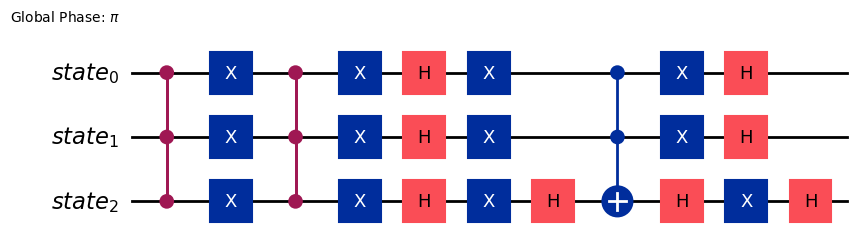

In [61]:
problem = AmplificationProblem(oracle, is_good_state=['000', '111'])
problem.grover_operator.decompose().draw(output='mpl')

In [62]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.circuit_results, result.iterations

([{'000': 0.4999999999999991, '111': 0.4999999999999991}], [1])

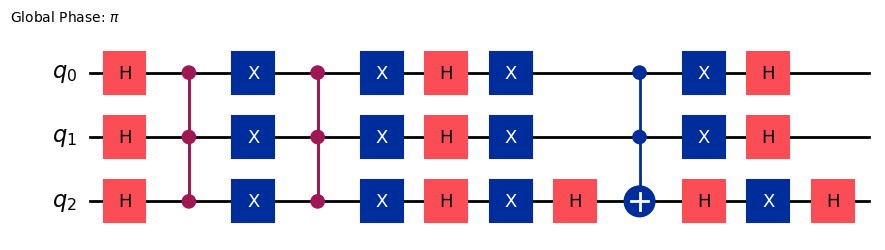

In [63]:
qc = QuantumCircuit(3)
qc.h(range(3))
qc.compose(problem.grover_operator.decompose(), inplace=True)
qc.draw('mpl')

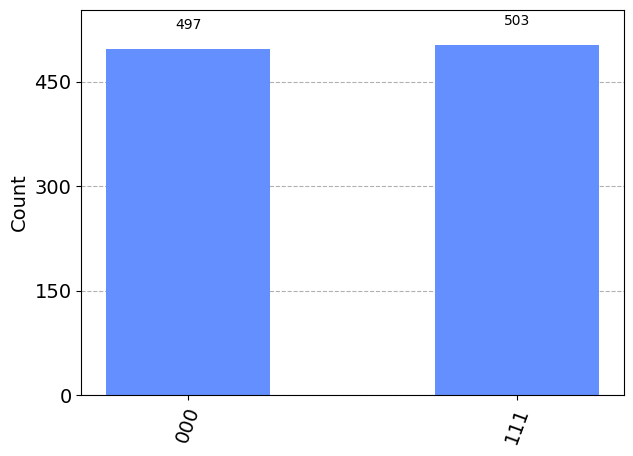

In [64]:
plot_histogram(get_result(qc))

In [65]:
oracle = QuantumCircuit(3, name="oracle")

oracle.x(0)
oracle.ccz(0,1,2)
oracle.x(0)

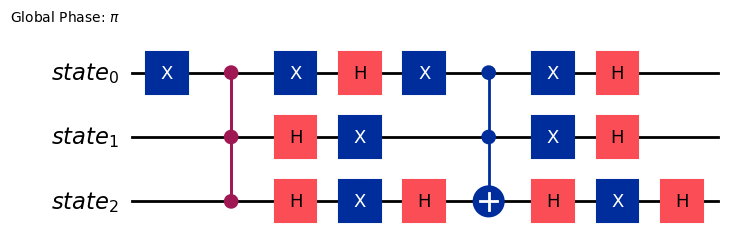

In [66]:
problem = AmplificationProblem(oracle, is_good_state=['110'])
problem.grover_operator.decompose().draw(output='mpl')

In [67]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.circuit_results, result.iterations

([{'000': 0.0312499999999999,
   '001': 0.0312499999999999,
   '010': 0.0312499999999999,
   '011': 0.0312499999999999,
   '100': 0.0312499999999999,
   '101': 0.0312499999999999,
   '110': 0.7812499999999987,
   '111': 0.0312499999999999}],
 [1])

In [68]:
def p_oracle(bit_string):
    bit_string = bit_string[::-1]
    zeros = [i for i, v in enumerate(bit_string) if v == '0']
    qc = QuantumCircuit(3)
    if(zeros):qc.x(zeros)
    qc.ccz(0,1,2)
    if(zeros):qc.x(zeros)
    return qc

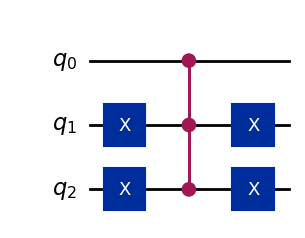

In [69]:
p_oracle('001').draw('mpl')

In [70]:
best_angle

1.7687958637858499

In [71]:
def compare(best_angle):
    for b in ['000', '001', '010', '011', '100', '101', '110', '111']:
        oracle = p_oracle(b)
        
        s = QuantumCircuit(3, name="S")
        s.ry(best_angle, range(3))
        new = new_g(s, oracle)
    
        old_problem = AmplificationProblem(oracle, is_good_state=[b])
        old = QuantumCircuit(3)
        old.h(range(3))
        old.compose(old_problem.grover_operator.decompose(), inplace=True)
    
        new_r = get_result(new)
        if(not new_r.get(b)):
            new_r = 0
        else:
            new_r = new_r[b]
            
        
        old_r = get_result(old)
        if(not old_r.get(b)):
            old_r = 0
        else:
            old_r = old_r[b]
    
        print(b, ' - ', old_r,new_r)
compare(best_angle)

000  -  780 693
001  -  797 721
010  -  792 732
011  -  786 771
100  -  786 746
101  -  765 787
110  -  773 778
111  -  778 853


In [72]:
best_angle, _ = find_best_angle('000', p_oracle('000'))
best_angle

0.0 579
0.026399938265460447 593
0.05279987653092089 604
0.07919981479638134 601
0.10559975306184179 640
0.13199969132730224 651
0.1583996295927627 640
0.18479956785822313 662
0.21119950612368357 687
0.23759944438914402 677
0.2639993826546045 696
0.29039932092006493 706
0.3167992591855254 747
0.3431991974509858 747
0.36959913571644626 752
0.3959990739819067 768
0.42239901224736714 777
0.4487989505128276 810
0.47519888877828803 799
0.5015988270437485 819
0.527998765309209 851
0.5543987035746694 844
0.5807986418401299 848
0.6071985801055902 857
0.6335985183710507 864
0.6599984566365111 861
0.6863983949019716 885
0.712798333167432 883
0.7391982714328925 899
0.7655982096983529 918
0.7919981479638134 891
0.8183980862292738 896
0.8447980244947343 916
0.8711979627601948 902
0.8975979010256552 922
0.9239978392911157 934
0.9503977775565761 923
0.9767977158220366 937
1.003197654087497 918
1.0295975923529574 927
1.055997530618418 934
1.0823974688838782 929
1.1087974071493387 908
1.135197345414799

0.9767977158220366

In [73]:
compare(best_angle)

000  -  757 924
001  -  778 641
010  -  800 659
011  -  782 520
100  -  764 653
101  -  768 484
110  -  764 510
111  -  773 455


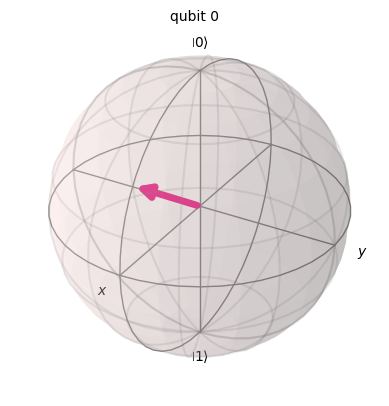

In [74]:
qc = QuantumCircuit(1)
qc.ry(best_angle, 0)
plot_bloch_multivector(qc)

In [75]:
best_angle, _ = find_best_angle('010', p_oracle('010'))
best_angle

0.0 69
0.026399938265460447 85
0.05279987653092089 80
0.07919981479638134 83
0.10559975306184179 107
0.13199969132730224 115
0.1583996295927627 127
0.18479956785822313 111
0.21119950612368357 136
0.23759944438914402 186
0.2639993826546045 155
0.29039932092006493 213
0.3167992591855254 226
0.3431991974509858 203
0.36959913571644626 256
0.3959990739819067 266
0.42239901224736714 257
0.4487989505128276 270
0.47519888877828803 297
0.5015988270437485 325
0.527998765309209 329
0.5543987035746694 335
0.5807986418401299 390
0.6071985801055902 409
0.6335985183710507 375
0.6599984566365111 443
0.6863983949019716 411
0.712798333167432 475
0.7391982714328925 511
0.7655982096983529 522
0.7919981479638134 525
0.8183980862292738 572
0.8447980244947343 543
0.8711979627601948 577
0.8975979010256552 570
0.9239978392911157 625
0.9503977775565761 604
0.9767977158220366 651
1.003197654087497 644
1.0295975923529574 672
1.055997530618418 706
1.0823974688838782 681
1.1087974071493387 729
1.1351973454147992 73

1.3199969132730223

In [76]:
compare(best_angle)

000  -  771 872
001  -  801 758
010  -  783 771
011  -  794 734
100  -  775 794
101  -  795 735
110  -  769 683
111  -  775 619


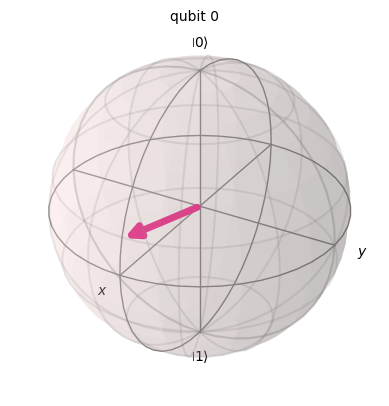

In [77]:
qc = QuantumCircuit(1)
qc.ry(best_angle, 0)
plot_bloch_multivector(qc)

In [83]:
old = {}
new = {}
bit_strings = ['000', '001', '010', '011', '100', '101', '110', '111']

for b in bit_strings:
    oracle = p_oracle(b)

    best_angle, _ = find_best_angle(b, oracle) 
    
    s = QuantumCircuit(3, name="S")
    s.ry(best_angle, range(3))
    new_ = new_g(s, oracle)
    
    old_problem = AmplificationProblem(oracle, is_good_state=[b])
    old_ = QuantumCircuit(3)
    old_.h(range(3))
    old_.compose(old_problem.grover_operator.decompose(), inplace=True)

    new_r = get_result(new_)
    if(not new_r.get(b)):
        new_r = 0
    else:
        new_r = new_r[b]
        
    
    old_r = get_result(old_)
    if(not old_r.get(b)):
        old_r = 0
    else:
        old_r = old_r[b]

    old[b] = old_r
    new[b] = new_r

0.0 544
0.026399938265460447 567
0.05279987653092089 549
0.07919981479638134 573
0.10559975306184179 617
0.13199969132730224 641
0.1583996295927627 630
0.18479956785822313 652
0.21119950612368357 682
0.23759944438914402 715
0.2639993826546045 683
0.29039932092006493 701
0.3167992591855254 733
0.3431991974509858 731
0.36959913571644626 759
0.3959990739819067 800
0.42239901224736714 782
0.4487989505128276 798
0.47519888877828803 786
0.5015988270437485 824
0.527998765309209 812
0.5543987035746694 846
0.5807986418401299 851
0.6071985801055902 865
0.6335985183710507 859
0.6599984566365111 865
0.6863983949019716 871
0.712798333167432 886
0.7391982714328925 901
0.7655982096983529 892
0.7919981479638134 915
0.8183980862292738 903
0.8447980244947343 927
0.8711979627601948 913
0.8975979010256552 917
0.9239978392911157 931
0.9503977775565761 926
0.9767977158220366 927
1.003197654087497 924
1.0295975923529574 928
1.055997530618418 925
1.0823974688838782 928
1.1087974071493387 923
1.135197345414799

In [84]:
old, new

({'000': 804,
  '001': 773,
  '010': 785,
  '011': 787,
  '100': 783,
  '101': 778,
  '110': 805,
  '111': 743},
 {'000': 945,
  '001': 776,
  '010': 783,
  '011': 782,
  '100': 791,
  '101': 783,
  '110': 804,
  '111': 920})

In [85]:
data = {"new": new, "old":old}
df = pd.DataFrame(data, columns=["new", "old"], index=bit_strings)
df

,new,old
000,945,804
001,776,773
010,783,785
011,782,787
100,791,783
101,783,778
110,804,805
111,920,743


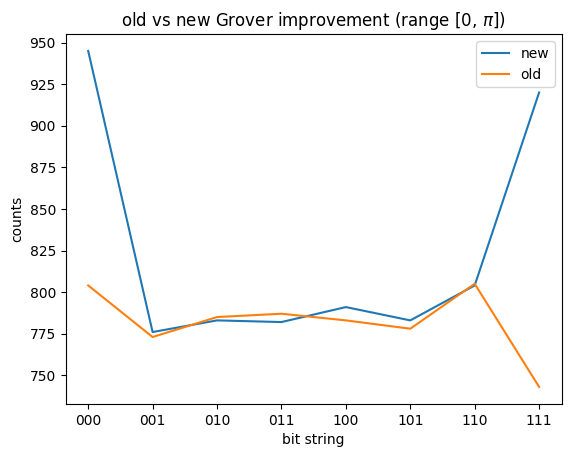

In [98]:
plt.plot(df.index.tolist(),df['new'], label="new")
plt.plot(df.index.tolist(),df['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("superposition-improvement-grover-algorithm.png"))
plt.show()


In [99]:
def find_best_angle_d_range(encoded_bit_string, oracle):
    max_ = 0
    best_angle = 0
    
    for angle in np.linspace(0, 2*np.pi, num=240):        
        s = QuantumCircuit(3)
        s.ry(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
    
        print(angle, result)
    return best_angle, max_

In [105]:
old = {}
new = {}
bit_strings = ['000', '001', '010', '011', '100', '101', '110', '111']

for b in bit_strings:
    oracle = p_oracle(b)

    best_angle, _ = find_best_angle_d_range(b, oracle) 
    
    s = QuantumCircuit(3, name="S")
    s.ry(best_angle, range(3))
    new_ = new_g(s, oracle)
    
    old_problem = AmplificationProblem(oracle, is_good_state=[b])
    old_ = QuantumCircuit(3)
    old_.h(range(3))
    old_.compose(old_problem.grover_operator.decompose(), inplace=True)

    new_r = get_result(new_)
    if(not new_r.get(b)):
        new_r = 0
    else:
        new_r = new_r[b]
        
    
    old_r = get_result(old_)
    if(not old_r.get(b)):
        old_r = 0
    else:
        old_r = old_r[b]

    old[b] = old_r
    new[b] = new_r

NameError: name 'find_best_angle_range' is not defined

In [101]:
data = {"new": new, "old":old}
df = pd.DataFrame(data, columns=["new", "old"], index=bit_strings)
df

,new,old
000,916,779
001,789,791
010,787,790
011,780,782
100,814,791
101,779,781
110,780,800
111,915,774


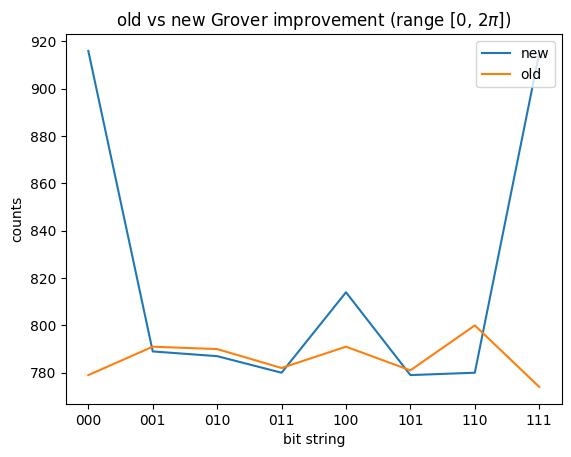

In [104]:
plt.plot(df.index.tolist(),df['new'], label="new")
plt.plot(df.index.tolist(),df['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

#plt.savefig(get_image_path("superposition-improvement-grover-algorithm.png"))
plt.show()

---

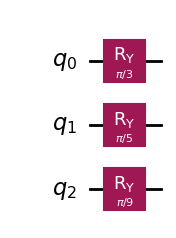

In [6]:
s = QuantumCircuit(3)
s.ry(np.pi/3, 0)
s.ry(np.pi/5, 1)
s.ry(np.pi/9, 2)
s.draw('mpl')

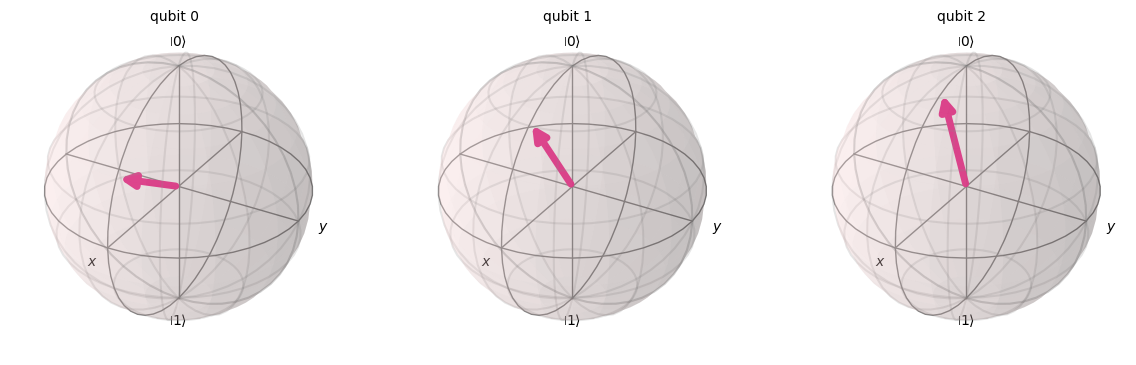

In [7]:
plot_bloch_multivector(s)

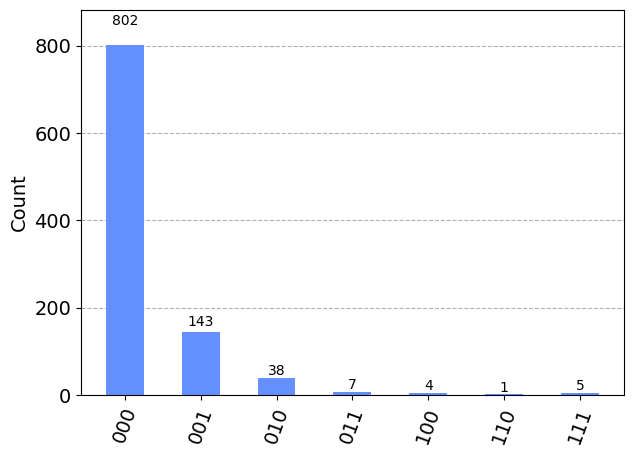

In [8]:
oracle = p_oracle('000')
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

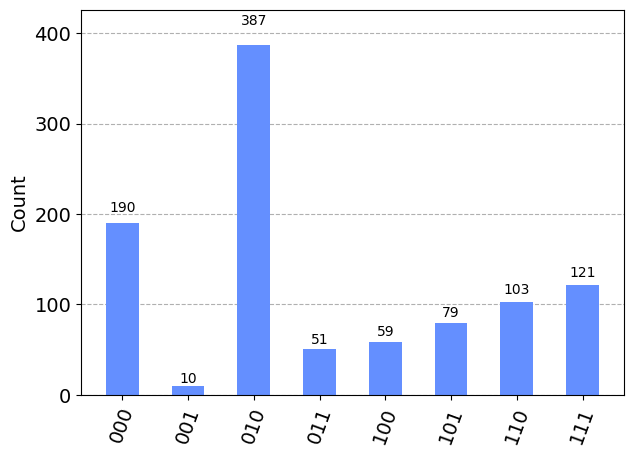

In [9]:
oracle = p_oracle('010')
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

---

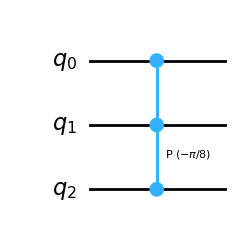

In [20]:
CCP = CPhaseGate(-np.pi/8).control(1)
oracle = QuantumCircuit(3)
oracle.append(CCP, [0, 1, 2])
oracle.draw('mpl')

In [21]:
qc_copy = oracle.copy()
qc_copy.save_unitary()

sim = AerSimulator()
unitary = sim.run(transpile(qc_copy, sim)).result().get_unitary()
array_to_latex(unitary, max_size=10000)

<IPython.core.display.Latex object>

In [24]:
s = QuantumCircuit(3)
s.ry(1.7423959255203896, range(3))

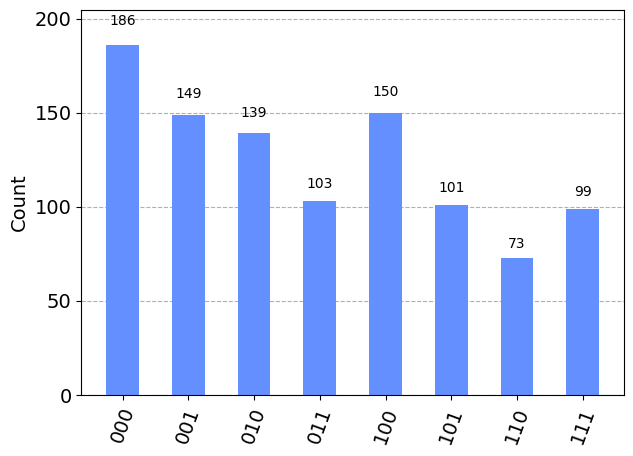

In [25]:
qc = new_g(s, oracle)
plot_histogram(get_result(qc))

---

In [25]:
sim = AerSimulator()

def find_best_angle_rx(encoded_bit_string, oracle):
    max_ = 0
    best_angle = 0
    
    for angle in np.linspace(0, np.pi, num=120):        
        s = QuantumCircuit(3)
        s.rx(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
            
        #transpiled = transpile(qc, sim)
        #display(transpiled.draw('mpl'))
    
        #print(angle, result)
    return best_angle, max_

In [26]:
def find_best_angle_rz(encoded_bit_string, oracle):
    max_ = 0
    best_angle = 0
    
    for angle in np.linspace(0, np.pi, num=120):        
        s = QuantumCircuit(3)
        s.rz(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
            
        #transpiled = transpile(qc, sim)
        #display(transpiled.draw('mpl'))
    
        #print(angle, result)
    return best_angle, max_

In [27]:
def find_best_angle_ry(encoded_bit_string, oracle):
    max_ = 0
    best_angle = 0
    
    for angle in np.linspace(0, np.pi, num=120):        
        s = QuantumCircuit(3)
        s.ry(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
            
        #transpiled = transpile(qc, sim)
        #display(transpiled.draw('mpl'))
    
        #print(angle, result)
    return best_angle, max_

In [28]:
rx = {}
rz = {}
ry = {}
bit_strings = ['000', '001', '010', '011', '100', '101', '110', '111']

for s in bit_strings:
    oracle = p_oracle(s)
    
    angle_rx, max_rx = find_best_angle_rx(s, oracle)
    angle_rz, max_rz = find_best_angle_rz(s, oracle)
    angle_ry, max_ry = find_best_angle_ry(s, oracle)
    
    print(s, angle_rx, max_rx, angle_rz, max_rz, angle_ry, max_ry)
    rx[s] = max_rx
    rz[s] = max_rz
    ry[s] = max_ry

000 0.0 598 1.6895960489894686 602 0.9503977775565761 935
001 1.293596975007562 210 0.3959990739819067 80 1.3991967280694038 799
010 1.0823974688838782 210 0.13199969132730224 87 1.5047964811312455 819
011 2.1647949377677564 221 2.851193332669728 84 1.715995987254929 815
100 1.0295975923529574 224 1.8479956785822313 85 1.5311964193967058 807
101 1.9535954316440731 218 3.1151927153243326 83 1.715995987254929 800
110 1.8479956785822313 209 0.5807986418401299 77 1.6367961724585476 805
111 3.0359929005279516 573 2.719193641342426 79 2.059195184705915 937


In [29]:
data = {"ry": ry, "rx": rx, "rz": rz}
df = pd.DataFrame(data, columns=("ry", "rx", "rz"), index=bit_strings)

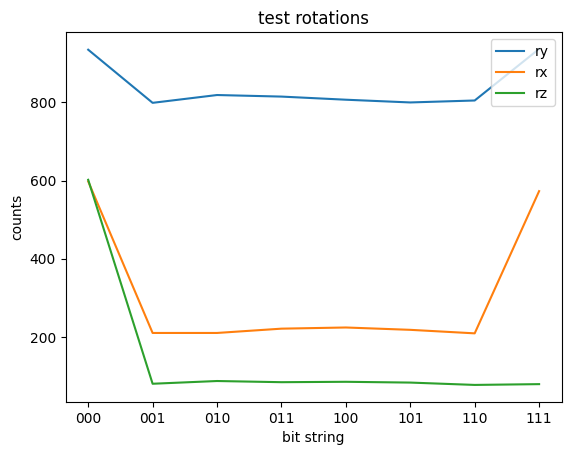

In [30]:
plt.plot(df.index.tolist(),df['ry'], label="ry")
plt.plot(df.index.tolist(),df['rx'], label="rx")
plt.plot(df.index.tolist(),df['rz'], label="rz")
plt.title('test rotations')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("rotations-test-grover-algorithm.png"))
plt.show()


---

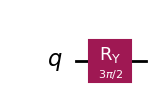

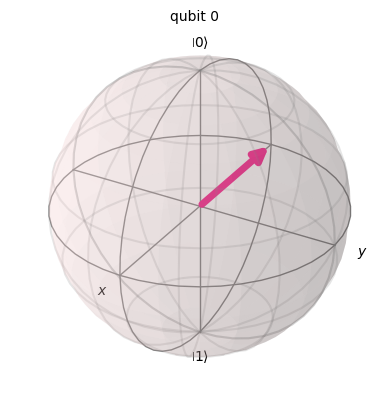

In [94]:
test = QuantumCircuit(1)
test.ry(3*np.pi/2, 0)

display(test.draw('mpl'))
plot_bloch_multivector(test)

---

In [112]:
def find_best_angle_2(encoded_bit_string, oracle, values_range, sim=AerSimulator()):
    max_ = 0
    best_angle = 0
    
    for angle in values_range:        
        s = QuantumCircuit(3)
        s.ry(angle, range(3))

        qc = new_g(s, oracle)
    
        qc.measure_all()
        result = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
        if(not result.get(encoded_bit_string)):
            continue
            
        result = result[encoded_bit_string]
        if(result > max_):
            max_ = result
            best_angle = angle
    
        #print(angle, result)
    return best_angle, max_

In [127]:
def new_compare(values_range, bit_strings=['000', '001', '010', '011', '100', '101', '110', '111']):
    old = {}
    new = {}

    total_qubits = len(bit_strings[0])
    
    for b in bit_strings:
        oracle = p_oracle(b)
    
        best_angle, _ = find_best_angle_2(b, oracle, values_range=values_range) 
        
        s = QuantumCircuit(total_qubits, name="S")
        s.ry(best_angle, range(total_qubits))

        new_ = QuantumCircuit(total_qubits)
        new_.append(s, range(total_qubits))
        new_.append(oracle, range(total_qubits))
      
        new_.h(range(total_qubits))
        new_.x(range(total_qubits))
        new_.h(-1)
        new_.mcmt(list(range(tota_qubits-1)),-1)
        new_.h(-1)
        new_.x(range(total_qubits))
        new_.h(range(total_qubits))
        
        old_problem = AmplificationProblem(oracle, is_good_state=[b])
        old_ = QuantumCircuit(total_qubits)
        old_.h(range(total_qubits))
        old_.compose(old_problem.grover_operator.decompose(), inplace=True)
    
        new_r = get_result(new_)
        if(not new_r.get(b)):
            new_r = 0
        else:
            new_r = new_r[b]
            
        
        old_r = get_result(old_)
        if(not old_r.get(b)):
            old_r = 0
        else:
            old_r = old_r[b]
    
        old[b] = old_r
        new[b] = new_r

    data = {"old": old, "new": new}
    df = pd.DataFrame(data, columns=("old", "new"), index=bit_strings)
    return df

In [128]:
df_0_to_pi = new_compare(np.linspace(0, np.pi, num=240))
df_0_to_pi

AttributeError: 'QuantumCircuit' object has no attribute 'mct'

In [ ]:
plt.plot(df_0_to_pi.index.tolist(),df_0_to_pi['old'], label="old")
plt.plot(df_0_to_pi.index.tolist(),df_0_to_pi['new'], label="new")
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")
plt.show()

In [ ]:
df_0_to_2pi = new_compare(np.linspace(0, 2*np.pi, num=240))
df_0_to_2pi

In [ ]:
plt.plot(df_0_to_2pi.index.tolist(),df_0_to_2pi['old'], label="old")
plt.plot(df_0_to_2pi.index.tolist(),df_0_to_2pi['new'], label="new")
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")
plt.show()

In [129]:
df_0_to_pi = new_compare(np.linspace(0, np.pi, num=240), bit_strings=['00', '01', '10', '11'])
df_0_to_pi

CircuitError: 'The amount of qubit arguments 2 does not match the instruction expectation (3).'